In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation,concatenate, Attention, Bidirectional,GlobalAveragePooling1D
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import keras_tuner as kt
import math
from datetime import datetime, timedelta
from scipy.stats import norm

In [2]:
def LSTMPrediction(training_df, time_step = 10, runs = 30, end_date=datetime.strftime(datetime.now(), '%Y-%m-%d')):

    #Data Scaling
    Xscaler = MinMaxScaler()
    Xdata = Xscaler.fit_transform(np.array(training_df))
    Xdata.shape
    Yscaler = MinMaxScaler()
    Ydata = Yscaler.fit_transform(np.array([training_df['Close']]).transpose())

    Xtrain_data, Xtest_data = train_test_split(Xdata, test_size=0.3, shuffle=False)
    Ytrain_data, Ytest_data = train_test_split(Ydata, test_size=0.3, shuffle=False)
    
    def build_timeseries(Xdata, Ydata, time_step):
        dim_0 = Xdata.shape[0] - time_step
        dim_1 = Xdata.shape[1]

        x = np.zeros((dim_0, time_step, dim_1))
        y = np.zeros((Ydata.shape[0] - time_step,))

        for i in range(dim_0):
            x[i] = Xdata[i:time_step+i]
            y[i] = Ydata[time_step+i]
        return x, y

    
    X_train, Y_train = build_timeseries(Xtrain_data, Ytrain_data.transpose()[0], time_step)
    X_test, Y_test = build_timeseries(Xtest_data, Ytest_data.transpose()[0], time_step)

    X_train = X_train.reshape((X_train.shape[0], time_step, X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], time_step, X_test.shape[2]))

    results = []
    prediction_data = np.array([X_test[-1]])
    for i in range(runs):
        print("RUN: ", i+1)
        model = Sequential()
        model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],X_train.shape[2])))
        model.add(LSTM(50,return_sequences = True))
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error',optimizer = 'adam')
        lstm_model = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 25,batch_size = 50, verbose = 1)
        prediction = model.predict(prediction_data)
        prediction = Yscaler.inverse_transform(prediction)[0][0]
        print("Prediction for: ", end_date, "        CLOSE: ", prediction)
        results.append(prediction)

    lastclose = Yscaler.inverse_transform([Ydata[-1]])[0][0]
    adjresults = np.array([x - lastclose for x in results])
    mu = adjresults.mean()
    std = adjresults.std()

    fig, ax = plt.subplots()
    xmin, xmax = plt.xlim()
    diff = pd.DataFrame(adjresults) 
    kde = diff.plot.kde(ax=ax, legend = False)
    diff.plot.hist(density=True, ax=ax, bins=20)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
    plt.title(title)
    plt.show()
    
    #Returns average change in price
    return mu


In [3]:
datadf = pd.read_csv('lstm_data.csv')
dataseparate = datadf[['Close', 'Open', 'High', 'Low', 'Volume', 'Negative', 'Neutral', 'Positive']]
display(dataseparate)

,Close,Open,High,Low,Volume,Negative,Neutral,Positive
0,4812.087402,4619.649414,4822.363281,4619.649414,19290896267,1.0,6.0,1.0
1,4735.068848,4810.071289,4837.589355,4718.039062,20834172627,1.0,6.0,3.0
2,4636.174316,4733.362793,4859.502930,4485.093262,22748160545,1.0,6.0,5.0
3,4730.384277,4635.453613,4778.059082,4580.990234,17933201129,2.0,6.0,2.0
4,4667.115234,4724.306641,4808.738770,4510.920410,18316060208,0.0,3.0,7.0
...,...,...,...,...,...,...,...,...
767,2219.337402,2316.110352,2316.892822,2214.263184,10259157898,20.0,24.0,20.0
768,2226.926514,2220.415527,2260.809814,2213.550781,6866555430,6.0,6.0,4.0
769,2196.481201,2226.892578,2244.366455,2195.761719,7410453853,2.0,8.0,12.0
770,2217.273438,2195.341797,2222.019287,2120.127441,10366536490,11.0,17.0,33.0


In [4]:
LSTMPrediction(dataseparate, end_date='2023-12-20')

RUN:  1


Epoch 1/25


KeyboardInterrupt: 

RUN:  1
Epoch 1/25
11/11 [==============================] - 4s 88ms/step - loss: 0.0520 - val_loss: 0.0076
Epoch 2/25
11/11 [==============================] - 0s 13ms/step - loss: 0.0087 - val_loss: 0.0012
Epoch 3/25
11/11 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 4/25
11/11 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 4.9890e-04
Epoch 5/25
11/11 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 5.7228e-04
Epoch 6/25
11/11 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 7.4540e-04
Epoch 7/25
11/11 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 5.8004e-04
Epoch 8/25
11/11 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 5.8617e-04
Epoch 9/25
11/11 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 5.4074e-04
Epoch 10/25
11/11 [==============================] - 0s 14ms/step - loss: 0.0

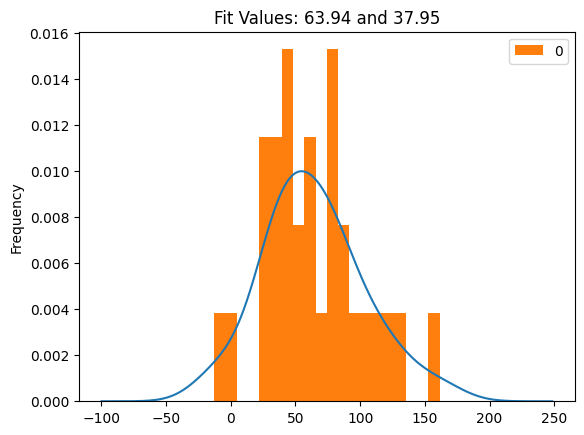

63.93540852864583

In [ ]:
dataindex = datadf[['Close', 'Open', 'High', 'Low', 'Volume', 'Sentiment']]
LSTMPrediction(dataindex, end_date='2023-12-20')